In [2]:
import os

os.environ["CHECKPOINTS_PATH"] = "../checkpoints"
os.environ["TRACKING_RESULTS_PATH"] = "data/processed_tracking_results"

import itertools
import shutil
from pathlib import Path

import matplotlib.pyplot as plt

from experiment.settings import (
    CLASS_ID_TO_NAME,
    FULLY_LABELED_RECORDINGS,
    LABELING_REC_SAME_BACKGROUND_ID,
    TRAINING_DATASETS_PATH,
    SIMROOM_ID,
    RECORDINGS_PATH,
    RECORDING_FRAMES_PATH,
    IGNORED_CLASS_IDS,
    OBJECT_DETECTION_MODELS_PATH,
)
from src.api.db import Session, engine
from src.api.repositories import simrooms_repo
from src.api.services import simrooms_service
import cv2
import numpy as np
from src.utils import extract_frames_to_dir
import albumentations as A
from tqdm import tqdm

%matplotlib inline

# Global Config

In [3]:
OBJECT_DETECTION_DATASETS_PATH = TRAINING_DATASETS_PATH / "object_detection"

In [5]:
def get_tracking_results_per_class(session: Session, labeling_recording_id: str):
    calibration_id = simrooms_repo.get_calibration_recording(
        session, simroom_id=SIMROOM_ID, recording_id=labeling_recording_id
    ).id
    tracked_classes = simrooms_repo.get_tracked_classes(session, calibration_id)

    tracked_classes = [
        tracked_class for tracked_class in tracked_classes
        if tracked_class.id not in IGNORED_CLASS_IDS
    ]

    if len(tracked_classes) != 14:
        raise ValueError(f"Expected 14 tracked classes but got {len(tracked_classes)}")

    tracking_results_per_class = {
        tracked_class.id: simrooms_repo.get_tracking_result_paths(
            session, calibration_id, tracked_class.id
        )
        for tracked_class in tracked_classes
    }

    return tracking_results_per_class, tracked_classes


def get_per_class_metadata(
    session: Session,
    labeling_recording_id: str,
    ignore_classes: list = None,
):
    tracking_results_per_class, tracked_classes = get_tracking_results_per_class(
        session, labeling_recording_id
    )
    per_class_metadata = {}

    for tracked_class in tracked_classes:
        if ignore_classes and tracked_class.id in ignore_classes:
            print(f"Class {CLASS_ID_TO_NAME[tracked_class.id]} is ignored, skipping it")
            continue

        class_id = tracked_class.id
        tracking_results = tracking_results_per_class[class_id]

        frame_indexes = []
        laplacian_variances = []
        mask_areas = []
        bboxes = []
        for tracking_result in tracking_results:
            file = np.load(tracking_result)
            if int(tracking_result.stem) != int(file["frame_idx"]):
                raise ValueError(
                    f"Frame index mismatch: {tracking_result.stem} != {file['frame_idx']}"
                )

            frame_indexes.append(int(tracking_result.stem))
            laplacian_variances.append(file["laplacian_variance"])
            mask_areas.append(np.sum(file["mask"]))
            bboxes.append(file["box"])

        per_class_metadata[class_id] = {
            "class_name": tracked_class.class_name,
            "color": tracked_class.color,
            "frame_indexes": frame_indexes,
            "laplacian_variances": laplacian_variances,
            "mask_areas": mask_areas,
            "bboxes": bboxes,
        }

    return per_class_metadata

# Create Training Data

In [ ]:
def select_samples_per_class(per_class_metadata, num_samples_per_class):
    selected_samples_per_class = {}

    for class_id, metadata in per_class_metadata.items():
        frame_indexes = metadata["frame_indexes"]
        bboxes = metadata["bboxes"]

        sample_list = list(zip(frame_indexes, bboxes))
        num_available = len(sample_list)

        selected_indices_list = []

        if num_available >= num_samples_per_class:
            # Enough samples available, sample WITHOUT replacement
            selected_indices_list = np.random.choice(
                num_available, size=num_samples_per_class, replace=False
            ).tolist()
        else:
            # Not enough samples (num_available < num_samples_per_class), so oversample.
            # First, include all available samples once.
            selected_indices_list.extend(list(range(num_available)))

            num_remaining_to_sample = num_samples_per_class - num_available

            if num_remaining_to_sample > 0:
                # Sample the remainder with replacement from the available samples.
                oversampled_indices = np.random.choice(
                    num_available, size=num_remaining_to_sample, replace=True
                ).tolist()
                selected_indices_list.extend(oversampled_indices)

            # Shuffle the combined list to mix original and oversampled instances.
            np.random.shuffle(selected_indices_list)

        # Retrieve the actual sample data using the selected indices.
        final_selected_samples_tuples = [sample_list[i] for i in selected_indices_list]
        selected_frame_indexes, selected_bboxes = zip(*final_selected_samples_tuples)

        selected_samples_per_class[class_id] = {
            "frame_indexes": list(selected_frame_indexes),
            "bboxes": list(selected_bboxes),
        }

    return selected_samples_per_class


def get_samples_per_frame(per_class_metadata):
    all_samples_per_frame = {}

    for class_id, metadata in per_class_metadata.items():
        frame_indexes = metadata["frame_indexes"]
        bboxes = metadata["bboxes"]

        # zip all metadata together
        sample_list = list(zip(frame_indexes, bboxes))

        for frame_index, bbox in sample_list:
            if frame_index not in all_samples_per_frame:
                all_samples_per_frame[frame_index] = []
            all_samples_per_frame[frame_index].append((class_id, bbox))

    return all_samples_per_frame


def get_train_val_split(
    selected_samples_per_class,
    train_ratio=0.8,
):
    selected_samples_per_class = {}
    val_samples_per_class = {}

    for class_id, metadata in selected_samples_per_class.items():
        frame_indexes = metadata["frame_indexes"]
        bboxes = metadata["bboxes"]

        # zip all metadata together
        sample_list = list(zip(frame_indexes, bboxes))

        # shuffle the samples
        np.random.shuffle(sample_list)

        # split the samples into train and val
        split_index = int(len(sample_list) * train_ratio)
        train_samples = sample_list[:split_index]
        val_samples = sample_list[split_index:]

        # unzip the selected samples
        train_frame_indexes, train_bboxes = zip(*train_samples)
        val_frame_indexes, val_bboxes = zip(*val_samples)

        selected_samples_per_class[class_id] = {
            "frame_indexes": train_frame_indexes,
            "bboxes": train_bboxes,
        }
        val_samples_per_class[class_id] = {
            "frame_indexes": val_frame_indexes,
            "bboxes": val_bboxes,
        }

    return selected_samples_per_class, val_samples_per_class


def plot_per_class_laplacian_variance(per_class_metadata):
    # Plot boxplots of laplacian variances per class in a single graph (one boxplot per class)
    fig, ax = plt.subplots(figsize=(12, 6))
    for class_id, metadata in per_class_metadata.items():
        laplacian_variances = metadata["laplacian_variances"]
        ax.boxplot(
            laplacian_variances,
            positions=[class_id],
            widths=0.5,
            patch_artist=True,
            boxprops=dict(facecolor=metadata["color"]),
        )
    ax.set_xticks(list(per_class_metadata.keys()))
    ax.set_xticklabels([
        metadata["class_name"] for metadata in per_class_metadata.values()
    ])
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")
    ax.set_xlabel("Class")
    ax.set_ylabel("Laplacian Variance")
    ax.set_title("Laplacian Variance per Class")
    plt.grid()
    plt.show()

    # Plot histograms of laplacian variances per class in a single figure (one histogram per row)
    fig, axs = plt.subplots(
        len(per_class_metadata), 1, figsize=(12, 6 * len(per_class_metadata))
    )
    for i, (class_id, metadata) in enumerate(per_class_metadata.items()):
        laplacian_variances = metadata["laplacian_variances"]
        axs[i].hist(
            laplacian_variances,
            bins=50,
            color=metadata["color"],
            alpha=0.7,
            edgecolor="black",
        )
        axs[i].set_title(f"Laplacian Variance Histogram - {metadata['class_name']}")
        axs[i].set_xlabel("Laplacian Variance")
        axs[i].set_ylabel("Frequency")
        axs[i].grid()
    plt.tight_layout()
    plt.show()

In [22]:
frames, tmp_frames_dir = simrooms_service.extract_tmp_frames(
    LABELING_REC_SAME_BACKGROUND_ID
)

In [ ]:
with Session(engine) as session:
    per_class_metadata = get_per_class_metadata(
        session, LABELING_REC_SAME_BACKGROUND_ID, IGNORED_CLASS_IDS
    )

plot_per_class_laplacian_variance(per_class_metadata)

Class ampulepoeder is ignored, skipping it


In [5]:
def draw_bboxes(
    image_np, bboxes, labels, class_name_map=None, color=(0, 255, 0), thickness=2
):
    img_res = image_np.copy()
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_thickness = 1

    if not isinstance(bboxes, (list, np.ndarray)):
        print(f"Warning: bboxes is not a list or ndarray: {type(bboxes)}")
        return img_res
    if not isinstance(labels, (list, np.ndarray)):
        print(f"Warning: labels is not a list or ndarray: {type(labels)}")
        # Attempt to proceed if labels seem usable, otherwise return
        if len(bboxes) != len(labels):
            print("Warning: bbox and label length mismatch, cannot draw labels.")
            labels = ["?" for _ in bboxes]  # Placeholder
        elif not all(isinstance(l, (str, int, float)) for l in labels):
            print("Warning: labels contain non-primitive types, cannot draw reliably.")
            labels = ["?" for _ in bboxes]

    for bbox, label in zip(bboxes, labels):
        # Assuming bbox format allows direct conversion to int x_min, y_min, x_max, y_max
        # This might need adjustment based on the ACTUAL format in your bboxes list
        # Example for pascal_voc or albumentations (after denormalizing)
        try:
            # Check if bbox has at least 4 elements
            if len(bbox) < 4:
                print(f"Warning: Skipping invalid bbox (fewer than 4 coords): {bbox}")
                continue
            x_min, y_min, x_max, y_max = map(int, bbox[:4])
        except (ValueError, TypeError) as e:
            print(f"Warning: Could not convert bbox coords to int: {bbox}, Error: {e}")
            continue  # Skip this bbox

        cv2.rectangle(img_res, (x_min, y_min), (x_max, y_max), color, thickness)

        label_name = (
            str(label)
            if class_name_map is None
            else class_name_map.get(label, str(label))
        )
        # Simple text placement above the box
        (text_width, text_height), baseline = cv2.getTextSize(
            label_name, font, font_scale, font_thickness
        )
        text_y = (
            y_min - baseline if y_min - baseline > text_height else y_min + text_height
        )
        cv2.putText(
            img_res, label_name, (x_min, text_y), font, font_scale, color, font_thickness
        )

    return img_res

In [ ]:
def get_selected_samples_per_frame(selected_samples_per_class):
    selected_samples_per_frame = {}
    for class_id, metadata in selected_samples_per_class.items():
        frame_indexes = metadata["frame_indexes"]
        bboxes = metadata["bboxes"]
        sample_list = list(zip(frame_indexes, bboxes))

        for frame_index, bbox in sample_list:
            if frame_index not in selected_samples_per_frame:
                selected_samples_per_frame[frame_index] = []
            selected_samples_per_frame[frame_index].append((class_id, bbox))

    return selected_samples_per_frame


def create_data_files(
    labels_path: Path,
    images_path: Path,
    class_label_to_model_id,
    sample_idx,
    image,
    bboxes,
    class_labels,
):
    padded_sample_idx = str(sample_idx).zfill(10)
    image_width, image_height = image.shape[1], image.shape[0]

    # Save image
    image_path = images_path / f"{padded_sample_idx}.jpg"
    cv2.imwrite(image_path, image)

    # Save labels
    labels_path = labels_path / f"{padded_sample_idx}.txt"

    # transform bboxes to YOLO format
    file_rows = []
    for bbox, class_label in zip(bboxes, class_labels):
        x1, y1, x2, y2 = bbox

        # get xywh format
        x_center = (x1 + x2) / 2
        y_center = (y1 + y2) / 2
        width = x2 - x1
        height = y2 - y1

        # normalize the values
        x_center /= image_width
        y_center /= image_height
        width /= image_width
        height /= image_height

        model_id = class_label_to_model_id[class_label]
        file_rows.append(f"{model_id} {x_center} {y_center} {width} {height}")

    with open(labels_path, "w") as f:
        for row in file_rows:
            f.write(row + "\n")

def create_crop_for_frame(
    image: np.ndarray,
    crop_size: int,
    box: tuple[int, int, int, int],
    bboxes: np.ndarray,
    class_labels: list[str],
    is_validation: bool = False,  
):
    x1, y1, x2, y2 = box
    cx, cy = (x1 + x2) // 2, (y1 + y2) // 2

    # create a crop around the center of the box
    half_crop = crop_size // 2
    x_min = max(0, cx - half_crop)
    y_min = max(0, cy - half_crop)
    x_max = min(image.shape[1], cx + half_crop)
    y_max = min(image.shape[0], cy + half_crop)

    transform_steps = [
        A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max),
        A.PadIfNeeded(min_height=crop_size, min_width=crop_size),
    ]

    if not is_validation:
        transform_steps.append(A.HorizontalFlip(p=0.5))
        transform_steps.append(A.RandomBrightnessContrast(p=0.2))

    transform = A.Compose(
        transform_steps,
        bbox_params=A.BboxParams(
            format="pascal_voc", label_fields=["class_labels"], min_visibility=0.7
        ),
    )

    # Augment the image and boxes
    augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed_image = augmented["image"]
    transformed_bboxes = augmented["bboxes"]
    transformed_class_labels = augmented["class_labels"]
    return transformed_image, transformed_bboxes, transformed_class_labels


def create_train_or_val_dataset(
    per_class_metadata,
    class_label_to_model_id,
    selected_samples_per_class,
    all_samples_per_frame,
    frames,
    images_path,
    labels_path,
    crop_size: int,
    is_validation=False,
):
    selected_samples_per_frame = get_selected_samples_per_frame(
        selected_samples_per_class
    )

    current_sample_idx = 0
    for frame_idx, frame in enumerate(tqdm(frames)):
        # check if the frame has any samples
        if selected_samples_per_frame.get(frame_idx) is None:
            continue

        image = cv2.imread(str(frame))

        # gather boxes and labels for the current frame
        class_ids, bboxes = zip(*all_samples_per_frame[frame_idx])
        bboxes = np.array(bboxes)
        class_labels = [
            per_class_metadata[class_id]["class_name"] for class_id in class_ids
        ]

        # for all selected samples in this frame, create crops
        for _, box in selected_samples_per_frame[frame_idx]:
            # create a crop for the current box
            transformed_image, transformed_bboxes, transformed_class_labels = create_crop_for_frame(
                image,
                crop_size,
                box,
                bboxes,
                class_labels,
                is_validation
            )

            # Save the transformed image and labels
            create_data_files(
                labels_path,
                images_path,
                class_label_to_model_id,
                current_sample_idx,
                transformed_image,
                transformed_bboxes,
                transformed_class_labels,
            )

            current_sample_idx += 1


def create_metadata_yaml(
    dataset_path: Path,
    per_class_metadata: dict,
):
    abs_dataset_path = dataset_path.resolve()

    metadata_yaml = f"""
path: {abs_dataset_path}
train: images/train
val: images/val
names:
"""

    class_label_to_model_id = {}
    for i, metadata in enumerate(per_class_metadata.values()):
        metadata_yaml += f"  {i}: {metadata['class_name']}\n"
        class_label_to_model_id[metadata["class_name"]] = i

    metadata_yaml_path = dataset_path / "data.yaml"
    with open(metadata_yaml_path, "w") as f:
        f.write(metadata_yaml)

    return class_label_to_model_id


def create_dataset(
    per_class_metadata: dict,
    frames: list[Path],
    datasets_path: Path,
    crop_size: int,
    dataset_type: str,
    num_samples_per_class: int,
):
    print(f"Creating dataset with {num_samples_per_class} samples per class")

    dataset_name = f"{dataset_type}_{crop_size}_{num_samples_per_class}"
    dataset_path = datasets_path / dataset_name
    train_images_path = dataset_path / "images/train"
    train_labels_path = dataset_path / "labels/train"
    val_images_path = dataset_path / "images/val"
    val_labels_path = dataset_path / "labels/val"

    train_images_path.mkdir(parents=True, exist_ok=True)
    train_labels_path.mkdir(parents=True, exist_ok=True)
    val_images_path.mkdir(parents=True, exist_ok=True)
    val_labels_path.mkdir(parents=True, exist_ok=True)

    # Gather necessary metadata
    selected_samples_per_class = select_samples_per_class(
        per_class_metadata, num_samples_per_class
    )
    all_samples_per_frame = get_samples_per_frame(per_class_metadata)
    train_samples_per_class, val_samples_per_class = get_train_val_split(
        selected_samples_per_class, train_ratio=0.8
    )

    # Create the dataset
    print(f"Creating training dataset")
    class_label_to_model_id = create_metadata_yaml(dataset_path, per_class_metadata)
    create_train_or_val_dataset(
        per_class_metadata,
        class_label_to_model_id,
        train_samples_per_class,
        all_samples_per_frame,
        frames,
        train_images_path,
        train_labels_path,
        crop_size=crop_size,
    )
    print(f"Creating validation dataset")
    create_train_or_val_dataset(
        per_class_metadata,
        class_label_to_model_id,
        val_samples_per_class,
        all_samples_per_frame,
        frames,
        val_images_path,
        val_labels_path,
        crop_size=crop_size,
        is_validation=True,
    )

    return dataset_path

# Analyze bounding box sizes

In [6]:
print(f"Extracting metadata for recording {LABELING_REC_SAME_BACKGROUND_ID}")
with Session(engine) as session:
    per_class_metadata = get_per_class_metadata(
        session, LABELING_REC_SAME_BACKGROUND_ID, IGNORED_CLASS_IDS
    )

Extracting metadata for recording d6fd0aed-b901-4863-bad8-7910dad693e0


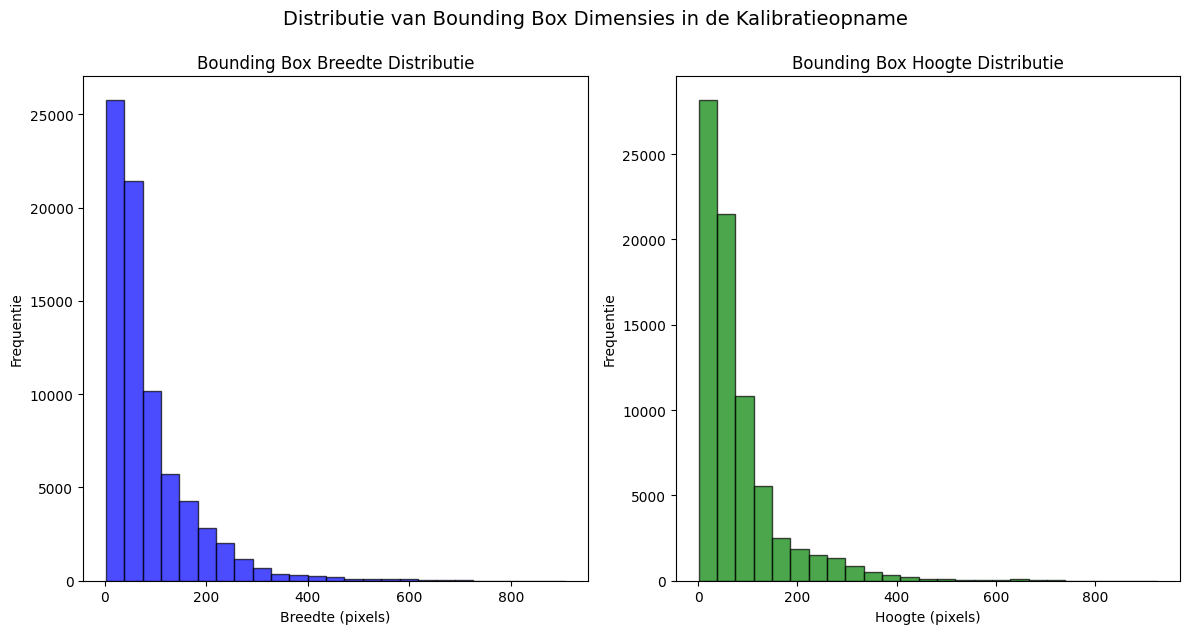

Breedte statistieken: min=3, max=906, gemiddelde=85.1, mediaan=57.0
Hoogte statistieken: min=1, max=924, gemiddelde=78.2, mediaan=50.0


In [ ]:

widths = []
heights = []

for class_id, metadata in per_class_metadata.items():
    boxes = metadata["bboxes"]

    for box in boxes:
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        widths.append(width)
        heights.append(height)

        
# plot histograms of widths and heights
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(widths, bins=25, color='blue', alpha=0.7, edgecolor='black')
plt.title("Bounding Box Breedte Distributie")
plt.xlabel("Breedte (pixels)")
plt.ylabel("Frequentie")
plt.subplot(1, 2, 2)
plt.hist(heights, bins=25, color='green', alpha=0.7, edgecolor='black')
plt.title("Bounding Box Hoogte Distributie")
plt.xlabel("Hoogte (pixels)")
plt.ylabel("Frequentie")
plt.tight_layout()
plt.suptitle("Distributie van Bounding Box Dimensies in de Kalibratieopname", y=1.05, fontsize=14)
plt.show()

# Calculate and print some statistics
print(f"Breedte statistieken: min={min(widths)}, max={max(widths)}, gemiddelde={np.mean(widths):.1f}, mediaan={np.median(widths)}")
print(f"Hoogte statistieken: min={min(heights)}, max={max(heights)}, gemiddelde={np.mean(heights):.1f}, mediaan={np.median(heights)}")



# Analyze number of samples per class

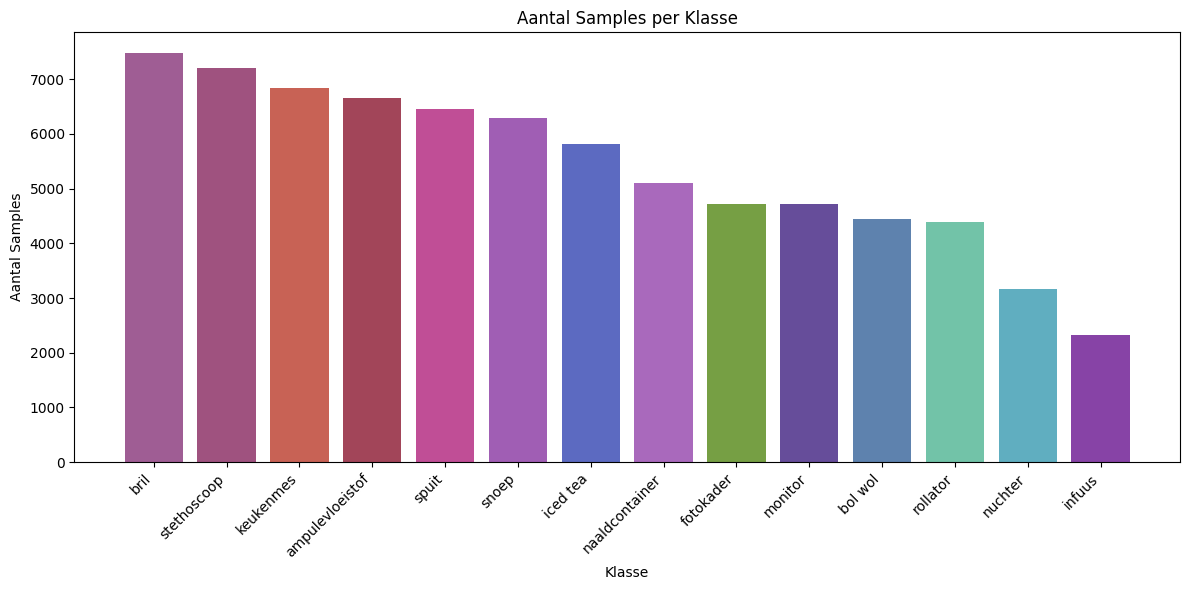

In [20]:
samples_per_class = {}

for class_id, metadata in per_class_metadata.items():
    samples_per_class[class_id] = len(metadata["frame_indexes"])

# Plot the number of samples per class in a bar chart, sorted by number of samples, and with the color of the class (metadata["color"])
sorted_samples_per_class = sorted(samples_per_class, key=samples_per_class.get, reverse=True)

plt.figure(figsize=(12, 6))
plt.bar(
    [CLASS_ID_TO_NAME[class_id] for class_id in sorted_samples_per_class],
    [samples_per_class[class_id] for class_id in sorted_samples_per_class],
    color=[per_class_metadata[class_id]["color"] for class_id in sorted_samples_per_class],
)
plt.xticks(rotation=45, ha='right')
plt.title("Aantal Samples per Klasse")
plt.xlabel("Klasse")
plt.ylabel("Aantal Samples")
plt.tight_layout()
plt.show()

In [9]:
if OBJECT_DETECTION_DATASETS_PATH.exists():
    shutil.rmtree(OBJECT_DETECTION_DATASETS_PATH)
OBJECT_DETECTION_DATASETS_PATH.mkdir(parents=True, exist_ok=True)

crop_size = [640]
dataset_type = ["same_background"]  # , "different_background", "mixed_background"]
num_samples_per_class = [500, 1000, 2000, 3000]

all_combinations = list(
    itertools.product(
        dataset_type,
        crop_size,
        num_samples_per_class,
    )
)

print(f"Creating datasets with {len(all_combinations)} combinations")

print(f"Extracting metadata for recording {LABELING_REC_SAME_BACKGROUND_ID}")
with Session(engine) as session:
    per_class_metadata = get_per_class_metadata(
        session, LABELING_REC_SAME_BACKGROUND_ID, IGNORED_CLASS_IDS
    )

print(f"Extracting frames for recording {LABELING_REC_SAME_BACKGROUND_ID}")
frames, tmp_frames_dir = simrooms_service.extract_tmp_frames(
    LABELING_REC_SAME_BACKGROUND_ID
)

for combination in tqdm(all_combinations, desc="Creating datasets"):
    dataset_type, crop_size, num_samples = combination

    dataset_path = create_dataset(
        per_class_metadata=per_class_metadata,
        frames=frames,
        datasets_path=OBJECT_DETECTION_DATASETS_PATH,
        crop_size=crop_size,
        dataset_type=dataset_type,
        num_samples_per_class=num_samples,
    )

Creating datasets with 4 combinations
Extracting metadata for recording d6fd0aed-b901-4863-bad8-7910dad693e0
Extracting frames for recording d6fd0aed-b901-4863-bad8-7910dad693e0


Creating datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Creating dataset with 500 samples per class
Creating training dataset


100%|██████████| 14121/14121 [00:27<00:00, 511.86it/s]


Creating validation dataset


Creating datasets:  25%|██▌       | 1/4 [00:35<01:45, 35.30s/it]

Creating dataset with 1000 samples per class
Creating training dataset


100%|██████████| 14121/14121 [00:47<00:00, 300.30it/s]


Creating validation dataset


Creating datasets:  50%|█████     | 2/4 [01:34<01:39, 49.55s/it]

Creating dataset with 2000 samples per class
Creating training dataset


100%|██████████| 14121/14121 [01:24<00:00, 167.06it/s]


Creating validation dataset


Creating datasets:  75%|███████▌  | 3/4 [03:24<01:16, 76.90s/it]

Creating dataset with 3000 samples per class
Creating training dataset


100%|██████████| 14121/14121 [01:49<00:00, 129.10it/s]


Creating validation dataset


Creating datasets: 100%|██████████| 4/4 [05:46<00:00, 86.68s/it] 


# Model Training

See `scripts/train_object_detectors.py`

## Extract frames for trial recordings

In [7]:
if not RECORDING_FRAMES_PATH.exists():
    RECORDING_FRAMES_PATH.mkdir(parents=True, exist_ok=True)

for recording_id in tqdm(FULLY_LABELED_RECORDINGS, desc="Extracting frames"):
    print(f"Extracting frames for {recording_id}")
    recording_video_path = RECORDINGS_PATH / f"{recording_id}.mp4"
    recording_frames_path = RECORDING_FRAMES_PATH / recording_id

    if recording_frames_path.exists():
        shutil.rmtree(recording_frames_path)
    recording_frames_path.mkdir(parents=True, exist_ok=True)

    extract_frames_to_dir(recording_video_path, recording_frames_path)

Extracting frames:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting frames for 67b71a70-da64-467a-9fb6-91bc29265fd1


Extracting frames:  10%|█         | 1/10 [00:07<01:03,  7.05s/it]

Extracting frames for 32f02db7-adc0-4556-a2da-ed2ba60a58c9


Extracting frames:  20%|██        | 2/10 [00:11<00:44,  5.57s/it]

Extracting frames for b8eeecc0-06b1-47f7-acb5-89aab3c1724d


Extracting frames:  30%|███       | 3/10 [00:16<00:37,  5.39s/it]

Extracting frames for d50c5f3b-2822-4462-9880-5a8f0dd46bfb


Extracting frames:  40%|████      | 4/10 [00:21<00:31,  5.29s/it]

Extracting frames for 9fa3e3b8-ed94-4b06-ba49-e66e3997d710


Extracting frames:  50%|█████     | 5/10 [00:25<00:24,  4.86s/it]

Extracting frames for 98128cdc-ffeb-40cb-9528-573e25028e87


Extracting frames:  60%|██████    | 6/10 [00:29<00:17,  4.32s/it]

Extracting frames for 89b60530-e0e4-4f5d-9ee6-af85c8d99ff4


Extracting frames:  70%|███████   | 7/10 [00:33<00:12,  4.29s/it]

Extracting frames for 2fe01600-c057-40ee-8434-4e9e0688ca2d


Extracting frames:  80%|████████  | 8/10 [00:40<00:10,  5.07s/it]

Extracting frames for 67823ccd-a1f0-4cde-b954-3b9e5fe160c1


Extracting frames:  90%|█████████ | 9/10 [00:45<00:05,  5.14s/it]

Extracting frames for b8f453aa-5a12-4cbb-a0ec-20eb503f8797


Extracting frames: 100%|██████████| 10/10 [00:50<00:00,  5.02s/it]
